In [1]:
%pylab inline

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

from itertools import product
from scipy import stats

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

from IPython.core.pylabtools import figsize
figsize(15, 7)

Populating the interactive namespace from numpy and matplotlib


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_20/datasets/ea_WAG_C_M.csv',';',
                   index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
WAG_C_M    284 non-null float64
dtypes: float64(1)
memory usage: 4.4 KB


In [4]:
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [0]:
df.WAG_C_M = df.WAG_C_M * 1000

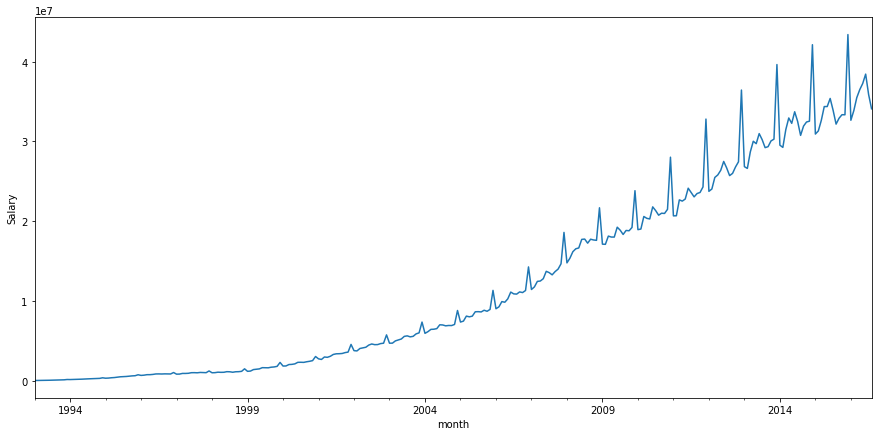

In [6]:
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

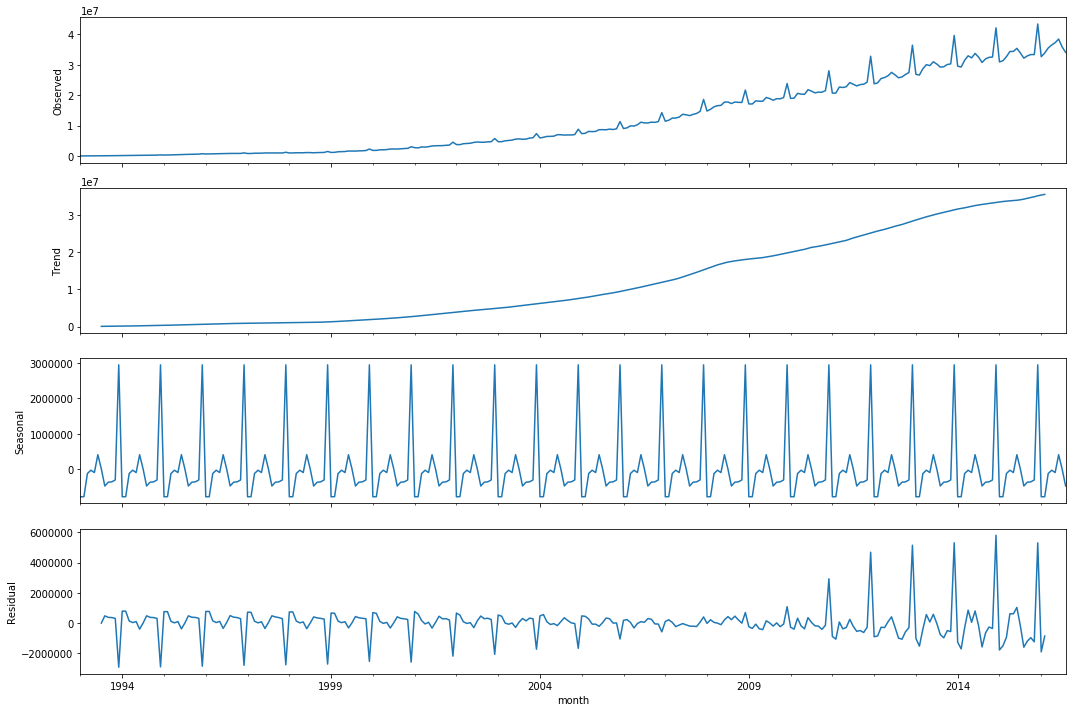

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [0]:
df['salary_box'], lmbda = stats.boxcox(df.WAG_C_M)

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


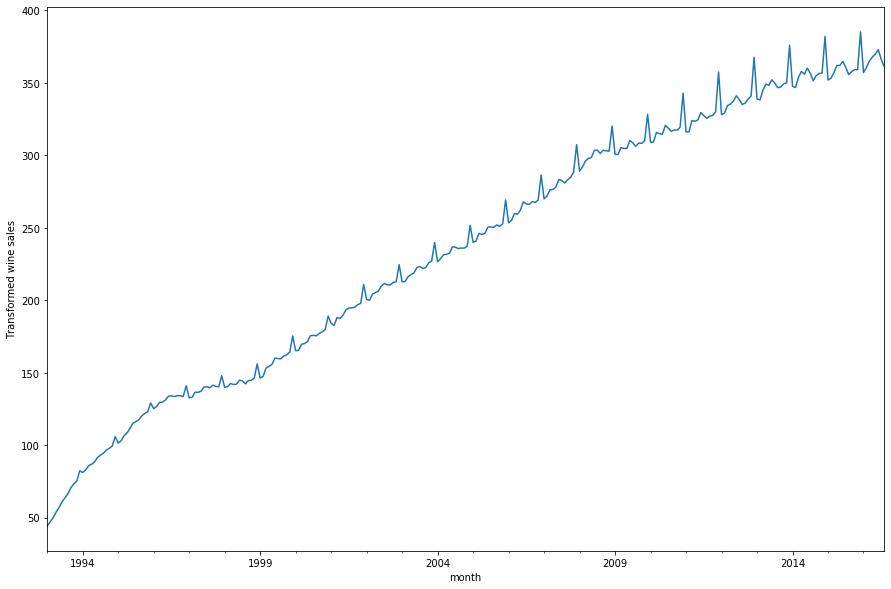

In [9]:
df.salary_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера подтверждает гипотезу нестационарности, визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

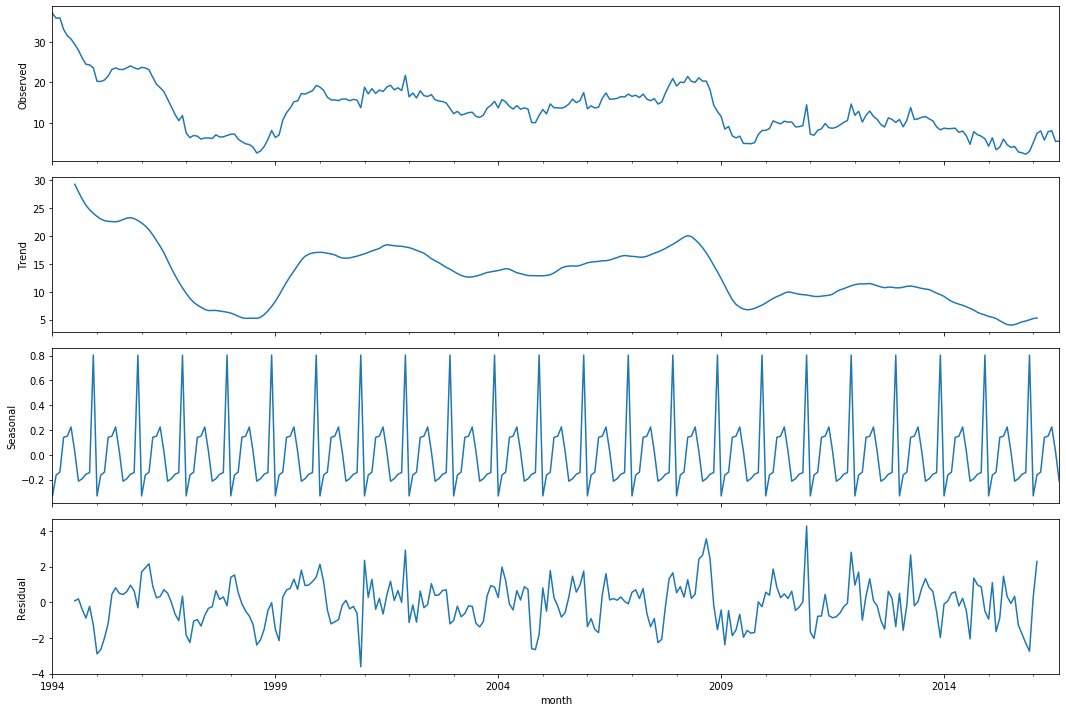

In [10]:
df['salary_box_diff'] = df.salary_box - df.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff[12:])[1])

Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

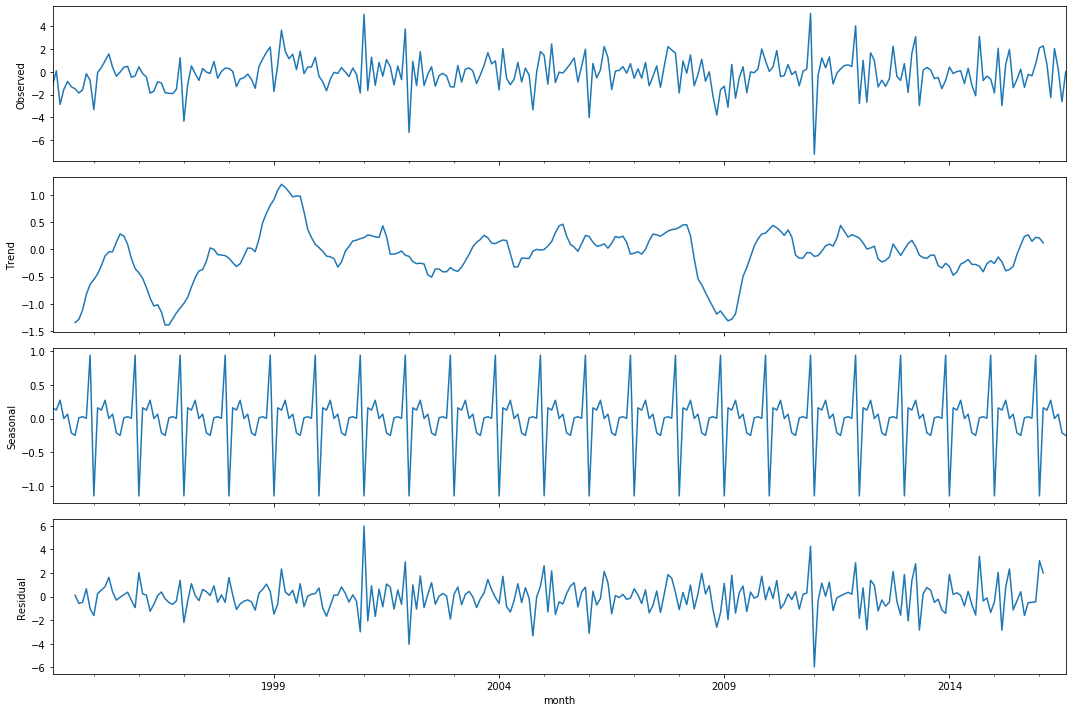

In [11]:
df['salary_box_diff']
df['salary_box_diff_2'] = df.salary_box_diff - df.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff_2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff_2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

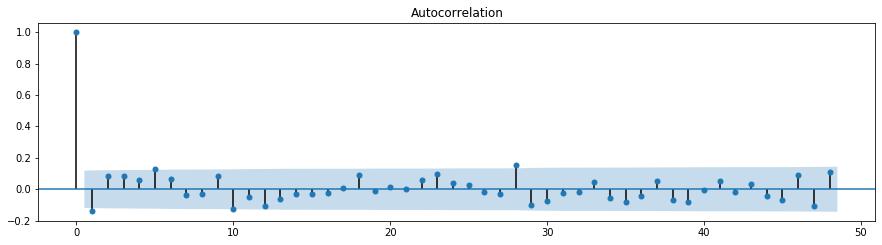

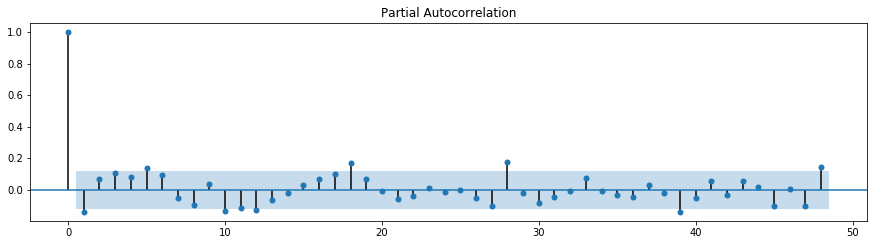

In [12]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.salary_box_diff_2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.salary_box_diff_2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=11, P=1, p=1

In [0]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [14]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [15]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 6.3 s, sys: 4.56 s, total: 10.9 s
Wall time: 5.61 s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
10  (1, 0, 1, 0)  985.768525
11  (1, 0, 1, 1)  985.920427
9   (1, 0, 0, 1)  986.202439
6   (0, 1, 1, 0)  986.598769
7   (0, 1, 1, 1)  986.770412


In [17]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -489.884
Date:                            Tue, 29 Oct 2019   AIC                            985.769
Time:                                    06:09:15   BIC                            996.575
Sample:                                01-01-1993   HQIC                           990.107
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090793


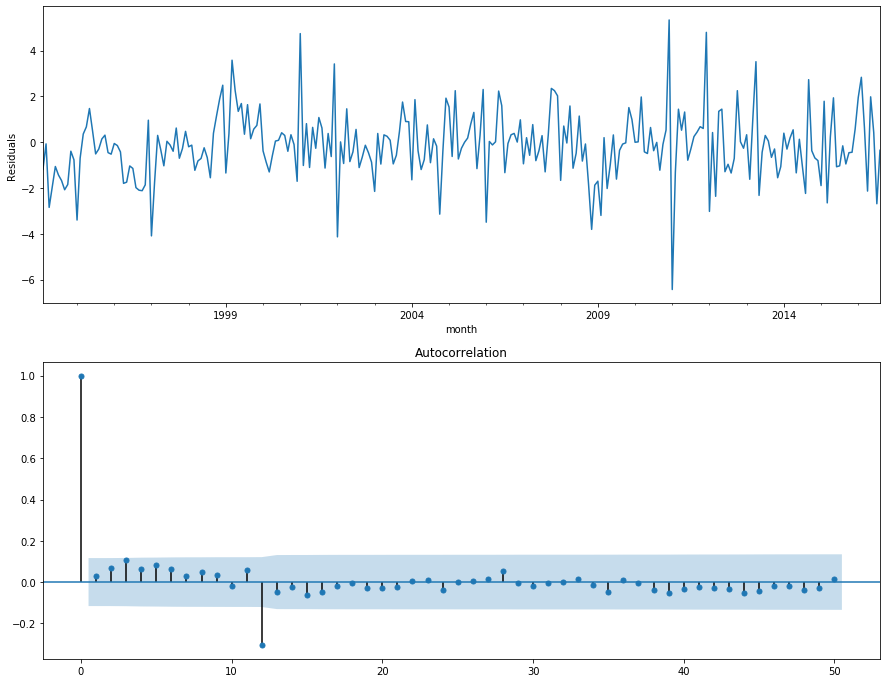

In [18]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(211)
_ = best_model.resid[13:].plot()
_ = plt.ylabel(u'Residuals')

_ = ax = plt.subplot(212)
_ = sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

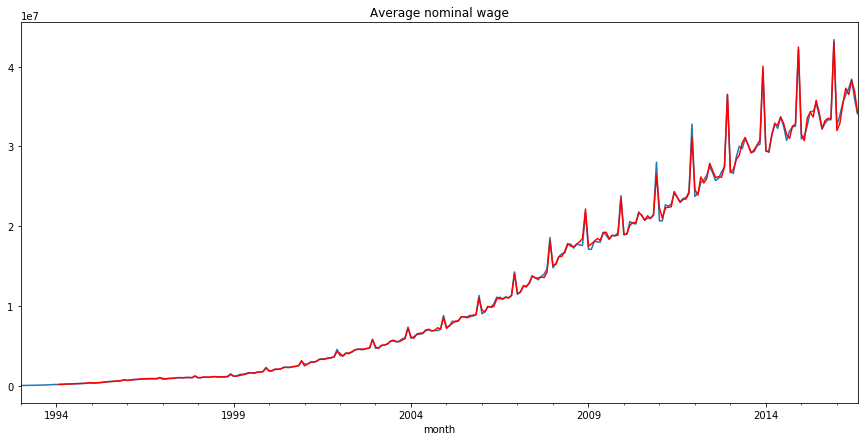

In [19]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)

_ = plt.figure(figsize=(15,7))
_ = df.WAG_C_M.plot()
_ = df.model[13:].plot(color='r')
_ = plt.title('Average nominal wage')

Прогноз

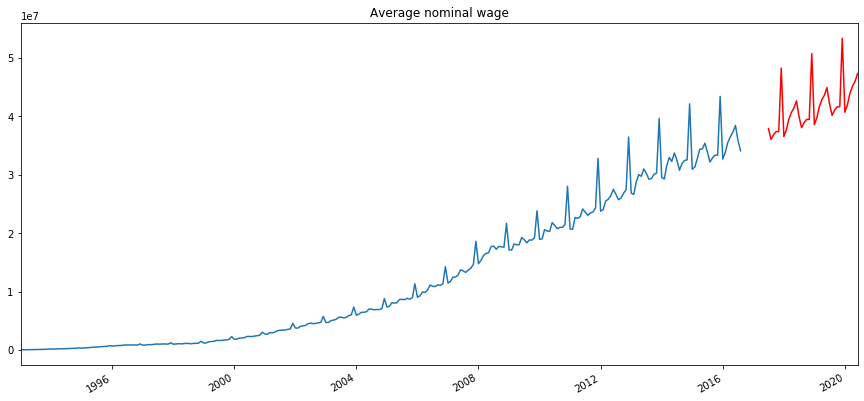

In [20]:
wage2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2017-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=294, end=329), lmbda)

_ = plt.figure(figsize=(15,7))
_ = wage2.WAG_C_M.plot()
_ = wage2.forecast.plot(color='r')
_ = plt.title('Average nominal wage')